# Online Retail — EDA and time-based feature extraction

In this notebook:
- load the UCI Online Retail dataset (Excel)
- basic EDA: shape, types, missing values, descriptive statistics
- data cleaning: dates, returns, invalid values, duplicates
- outlier handling (robust clipping)
- feature extraction at the customer (CustomerID) level: frequencies, totals, seasonality, intervals
- save the final feature dataset to CSV

Source: https://archive.ics.uci.edu/dataset/352/online+retail


In [3]:
# Imports
import os
import io
import math
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)
EXCEL_PATH = os.path.join(DATA_DIR, 'Online_Retail.xlsx')
FEATURES_PATH = os.path.join(DATA_DIR, 'customer_features.csv')

# Possible URLs (old/new UCI paths)
CANDIDATE_URLS = [
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx?download',
]


In [4]:
# Excel download: try to fetch if the file is missing
if not os.path.exists(EXCEL_PATH):
    import requests
    for url in CANDIDATE_URLS:
        try:
            print(f'Trying to download: {url}')
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            with open(EXCEL_PATH, 'wb') as f:
                f.write(r.content)
            print('Downloaded to:', EXCEL_PATH)
            break
        except Exception as e:
            print('Failed:', e)

if not os.path.exists(EXCEL_PATH):
    print('Could not download the dataset automatically. Please download the Excel file manually and place it into the data folder as Online_Retail.xlsx')
else:
    print('Dataset ready at:', EXCEL_PATH)


Dataset ready at: data/Online_Retail.xlsx


In [5]:
# Read Excel
assert os.path.exists(EXCEL_PATH), 'Excel file not found. Run the download cell or put the file into data.'
df = pd.read_excel(EXCEL_PATH)
print('Shape:', df.shape)
df.head(3)


Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [6]:
# Basic EDA
print(df.info())
print(df.describe(include='all').T)
print('Missing values by column:')
print(df.isna().sum())
print('Duplicates:', df.duplicated().sum())
print(list(df.columns))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
                count   unique                                 top    freq  \
InvoiceNo    541909.0  25900.0                            573585.0  1114.0   
StockCode      541909     4070                              85123A    2313   
Description    540455     4223  WHITE HANGING HEART T-LIGHT HOLDER   

In [7]:
# Type conversion and basic cleaning
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
# Return flag by invoice number (returns often start with 'C')
df['is_return'] = df['InvoiceNo'].astype(str).str.startswith('C')

# Create a valid slice of sales (exclude returns and anomalous values)
sales = df[~df['is_return']].copy()
# Remove invalid quantities/prices
sales = sales[(sales['Quantity'] > 0) & (sales['UnitPrice'] > 0)]
# Drop duplicates
sales = sales.drop_duplicates()
# Basic per-transaction features
sales['TotalPrice'] = sales['Quantity'] * sales['UnitPrice']
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'], errors='coerce')
sales = sales.dropna(subset=['InvoiceDate'])

print('Sales (after cleaning) shape:', sales.shape)
sales.head(3)


Sales (after cleaning) shape: (524878, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00


In [8]:
# Outlier handling for Quantity and UnitPrice via IQR clipping
def iqr_clip(series, k=3.0):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    return series.clip(lower=low, upper=high)

sales['Quantity_clipped'] = iqr_clip(sales['Quantity'])
sales['UnitPrice_clipped'] = iqr_clip(sales['UnitPrice'])
sales['TotalPrice_clipped'] = sales['Quantity_clipped'] * sales['UnitPrice_clipped']
sales[['Quantity','Quantity_clipped','UnitPrice','UnitPrice_clipped']].describe()


,Quantity,Quantity_clipped,UnitPrice,UnitPrice_clipped
count,524878.000000,524878.000000,524878.000000,524878.000000
mean,10.616600,7.603927,3.922573,3.157893
std,156.280031,9.611242,36.093028,2.931014
min,1.000000,1.000000,0.001000,0.001000
25%,1.000000,1.000000,1.250000,1.250000
50%,4.000000,4.000000,2.080000,2.080000
75%,11.000000,11.000000,4.130000,4.130000
max,80995.000000,41.000000,13541.330000,12.770000


In [9]:
# Temporal fields
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'])
sales['InvoiceYear'] = sales['InvoiceDate'].dt.year
sales['InvoiceMonth'] = sales['InvoiceDate'].dt.month
sales['InvoiceWeek'] = sales['InvoiceDate'].dt.isocalendar().week.astype(int)
sales['InvoiceWeekday'] = sales['InvoiceDate'].dt.weekday  # 0=Mon
sales['is_weekend'] = sales['InvoiceWeekday'] >= 5
sales['is_holiday_season'] = sales['InvoiceMonth'].isin([11, 12])
sales['InvoiceDateOnly'] = sales['InvoiceDate'].dt.date

# Data period boundaries
dataset_start = sales['InvoiceDate'].min()
dataset_end = sales['InvoiceDate'].max()
dataset_start, dataset_end


(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:50:00'))

In [10]:
# Aggregations by invoice (InvoiceNo) to count transactions
invoice_agg = (sales
    .groupby(['CustomerID','InvoiceNo'], as_index=False)
    .agg(
        invoice_date=('InvoiceDate','max'),
        items=('Quantity_clipped','sum'),
        revenue=('TotalPrice_clipped','sum')
    )
)
print('Invoice-level shape:', invoice_agg.shape)
invoice_agg.head(3)


Invoice-level shape: (18532, 5)


,CustomerID,InvoiceNo,invoice_date,items,revenue
0,12346.0,541431,2011-01-18 10:01:00,41,42.64
1,12347.0,537626,2010-12-07 14:57:00,319,711.79
2,12347.0,542237,2011-01-26 14:30:00,315,475.39


In [11]:
# Helper functions for interpurchase intervals
def interpurchase_stats(dates: pd.Series):
    dates = pd.to_datetime(dates).sort_values()
    if len(dates) < 2:
        return pd.Series({
            'recency_days': np.nan,
            'tenure_days': 0.0,
            'ipi_mean_days': np.nan,
            'ipi_median_days': np.nan,
        })
    diffs = dates.diff().dropna().dt.total_seconds() / 86400.0
    tenure = (dates.max() - dates.min()).total_seconds() / 86400.0
    recency = (dataset_end - dates.max()).total_seconds() / 86400.0
    return pd.Series({
        'recency_days': recency,
        'tenure_days': tenure,
        'ipi_mean_days': diffs.mean(),
        'ipi_median_days': diffs.median(),
    })

# Transaction frequencies
def txn_rates(dates: pd.Series):
    dates = pd.to_datetime(dates).sort_values()
    if dates.empty:
        return pd.Series({'txn_per_week': 0.0, 'txn_per_month': 0.0})
    span_days = max(1.0, (dates.max() - dates.min()).days + 1)
    per_week = len(dates) / (span_days / 7.0)
    per_month = len(dates) / (span_days / 30.4375)  # average month length
    return pd.Series({'txn_per_week': per_week, 'txn_per_month': per_month})


In [12]:
# Customer-level features
cust_base = invoice_agg.groupby('CustomerID').agg(
    total_transactions=('InvoiceNo','nunique'),
    total_items=('items','sum'),
    total_spent=('revenue','sum'),
    first_purchase=('invoice_date','min'),
    last_purchase=('invoice_date','max'),
).reset_index()
cust_base['avg_basket_value'] = cust_base['total_spent'] / cust_base['total_transactions']
cust_base['avg_items_per_txn'] = cust_base['total_items'] / cust_base['total_transactions']

# Additional unit-level averages
cust_unit = (sales.groupby('CustomerID').agg(
    unitprice_mean=('UnitPrice_clipped','mean'),
    unitprice_median=('UnitPrice_clipped','median'),
    unitprice_std=('UnitPrice_clipped','std'),
)).reset_index()

# Frequencies
cust_txn_rates = (invoice_agg.groupby('CustomerID')['invoice_date']
                  .apply(lambda s: txn_rates(s))
                  .reset_index())
cust_txn_rates = cust_txn_rates.pivot(index='CustomerID', columns='level_1', values='invoice_date').reset_index()

# Intervals
cust_ipi = (invoice_agg.groupby('CustomerID')['invoice_date']
            .apply(lambda s: interpurchase_stats(s))
            .reset_index())
cust_ipi = cust_ipi.pivot(index='CustomerID', columns='level_1', values='invoice_date').reset_index()

# Seasonality/patterns
cust_season = (sales.groupby('CustomerID').agg(
    share_weekend=('is_weekend', 'mean'),
    share_holiday_season=('is_holiday_season', 'mean'),
    month_mode=('InvoiceMonth', lambda s: s.mode().iloc[0] if not s.mode().empty else np.nan),
)).reset_index()

# Merge all blocks
from functools import reduce
dfs = [cust_base, cust_unit, cust_txn_rates, cust_ipi, cust_season]
features = reduce(lambda left, right: pd.merge(left, right, on='CustomerID', how='left'), dfs)

# Remove infinities and clean types
features = features.replace([np.inf, -np.inf], np.nan)
print('Features shape:', features.shape)
features.head(10)


Features shape: (4338, 20)


,CustomerID,total_transactions,total_items,total_spent,first_purchase,last_purchase,avg_basket_value,avg_items_per_txn,unitprice_mean,unitprice_median,unitprice_std,txn_per_month,txn_per_week,ipi_mean_days,ipi_median_days,recency_days,tenure_days,share_weekend,share_holiday_season,month_mode
0,12346.0,1,41,42.64,2011-01-18 10:01:00,2011-01-18 10:01:00,42.640000,41.000000,1.040000,1.040,NaN,30.437500,7.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1
1,12347.0,7,2252,4090.51,2010-12-07 14:57:00,2011-12-07 15:52:00,584.358571,321.714286,2.644011,2.015,2.255381,0.582138,0.133880,60.839699,58.460069,1.873611,365.038194,0.000000,0.230769,10
2,12348.0,4,1010,812.34,2010-12-16 19:09:00,2011-09-25 13:13:00,203.085000,252.500000,2.251290,0.550,4.133071,0.430212,0.098940,94.250926,70.003472,74.984028,282.752778,0.096774,0.548387,12
3,12349.0,1,631,1430.42,2011-11-21 09:51:00,2011-11-21 09:51:00,1430.420000,631.000000,3.938493,2.550,3.462978,30.437500,7.000000,NaN,NaN,NaN,0.000000,0.000000,1.000000,11
4,12350.0,1,197,307.17,2011-02-02 16:01:00,2011-02-02 16:01:00,307.170000,197.000000,2.239412,1.650,2.770926,30.437500,7.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,2
5,12352.0,8,536,1513.44,2011-02-16 12:33:00,2011-11-03 14:37:00,189.180000,67.000000,4.893765,4.250,3.753654,0.932950,0.214559,37.155159,13.100000,35.925694,260.086111,0.000000,0.176471,9
6,12353.0,1,20,89.00,2011-05-19 17:47:00,2011-05-19 17:47:00,89.000000,20.000000,6.075000,6.450,4.516175,30.437500,7.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,5
7,12354.0,1,530,1064.68,2011-04-21 13:11:00,2011-04-21 13:11:00,1064.680000,530.000000,4.250000,2.950,3.677230,30.437500,7.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,4
8,12355.0,1,166,366.90,2011-05-09 13:49:00,2011-05-09 13:49:00,366.900000,166.000000,4.203846,2.950,3.464490,30.437500,7.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,5
9,12356.0,3,1296,2521.49,2011-01-18 09:50:00,2011-11-17 08:40:00,840.496667,432.000000,3.112542,1.250,3.675167,0.301361,0.069307,151.475694,151.475694,22.173611,302.951389,0.000000,0.033898,1


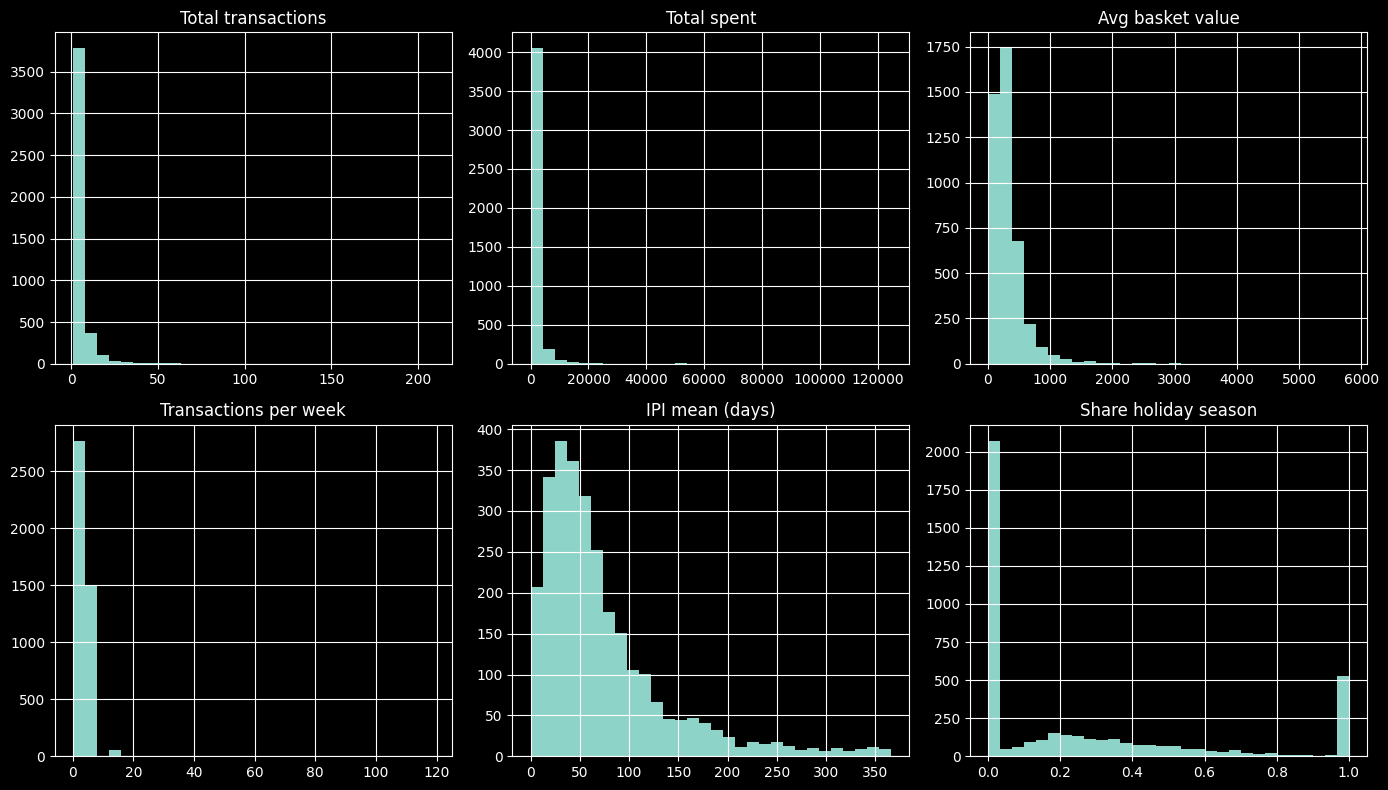

In [13]:
# Simple distribution visualizations
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
features['total_transactions'].hist(ax=axes[0], bins=30)
axes[0].set_title('Total transactions')
features['total_spent'].hist(ax=axes[1], bins=30)
axes[1].set_title('Total spent')
features['avg_basket_value'].hist(ax=axes[2], bins=30)
axes[2].set_title('Avg basket value')
features['txn_per_week'].hist(ax=axes[3], bins=30)
axes[3].set_title('Transactions per week')
features['ipi_mean_days'].hist(ax=axes[4], bins=30)
axes[4].set_title('IPI mean (days)')
features['share_holiday_season'].hist(ax=axes[5], bins=30)
axes[5].set_title('Share holiday season')
plt.tight_layout()
plt.show()


# Cluster analysis and interpretation


In [14]:
# Prepare required paths and inputs (be robust to execution order)
CLUSTERS_ASSIGN_PATH = os.path.join(DATA_DIR, 'cluster_assignments_week.csv')
CLUSTERS_PROFILE_PATH = os.path.join(DATA_DIR, 'cluster_profiles_week.csv')

# Load assignments if not in memory
if 'assign_df' not in globals():
    assert os.path.exists(CLUSTERS_ASSIGN_PATH), 'cluster_assignments_week.csv is missing. Run clustering cells first.'
    assign_df = pd.read_csv(CLUSTERS_ASSIGN_PATH)

# Load centroid profiles if not in memory
if 'profiles' not in globals():
    assert os.path.exists(CLUSTERS_PROFILE_PATH), 'cluster_profiles_week.csv is missing. Run clustering cells first.'
    profiles = pd.read_csv(CLUSTERS_PROFILE_PATH, parse_dates=['period'])

# Rebuild centroids wide if not available
if 'centroids' not in globals():
    # pivot profiles back to wide to compute stats per cluster
    centroids = profiles.pivot_table(index='cluster', columns='period', values=[c for c in profiles.columns if c not in ['cluster','period']][0])
    centroids = centroids.reset_index()

# Load customer-level features created earlier
assert os.path.exists(FEATURES_PATH), 'Customer features CSV not found. Run the feature extraction cells above first.'
cust_feat = pd.read_csv(FEATURES_PATH, parse_dates=['first_purchase','last_purchase'])

# Merge assignments with features
clusters_df = assign_df.merge(cust_feat, on='CustomerID', how='left')

# Compute cluster-level aggregates for key behavioral metrics
cluster_summary = (clusters_df
    .groupby('cluster')
    .agg(
        size=('CustomerID','nunique'),
        avg_txn_per_week=('txn_per_week','mean'),
        avg_txn_per_month=('txn_per_month','mean'),
        avg_total_spent=('total_spent','mean'),
        median_total_spent=('total_spent','median'),
        avg_basket_value=('avg_basket_value','mean'),
        median_basket_value=('avg_basket_value','median'),
        avg_recency_days=('recency_days','mean'),
        avg_tenure_days=('tenure_days','mean'),
        share_weekend_mean=('share_weekend','mean'),
        share_holiday_season_mean=('share_holiday_season','mean'),
    )
    .reset_index()
)

# Add share of customers per cluster
total_customers = clusters_df['CustomerID'].nunique()
cluster_summary['share'] = cluster_summary['size'] / max(1, total_customers)

# Derive variability/seasonality indicators from centroid profiles
# We already computed `centroids` (clusters × weeks, values in [0,1]) above.
centroid_only = centroids.drop(columns=['cluster']).copy()
centroid_stats = pd.DataFrame({
    'cluster': range(centroids.shape[0]),
    'centroid_mean': centroid_only.mean(axis=1).values,
    'centroid_std': centroid_only.std(axis=1).values,
})
centroid_stats['centroid_cv'] = np.where(centroid_stats['centroid_mean'] > 0,
                                         centroid_stats['centroid_std'] / centroid_stats['centroid_mean'], 0.0)

# Merge centroid stats into cluster summary
cluster_summary = cluster_summary.merge(centroid_stats, on='cluster', how='left')

# Simple rule-based labeling to produce human-readable tags
q_txn = cluster_summary['avg_txn_per_week'].quantile(0.75)
q_basket = cluster_summary['avg_basket_value'].quantile(0.75)
q_cv = cluster_summary['centroid_cv'].quantile(0.75)
q_holiday = cluster_summary['share_holiday_season_mean'].quantile(0.75)

labels = []
rationales = []
for _, row in cluster_summary.iterrows():
    tags = []
    reasons = []
    if pd.notna(row['avg_txn_per_week']) and row['avg_txn_per_week'] >= q_txn:
        tags.append('frequent buyers')
        reasons.append(f"txn_per_week ≥ P75 ({row['avg_txn_per_week']:.2f} ≥ {q_txn:.2f})")
    if pd.notna(row['avg_basket_value']) and row['avg_basket_value'] >= q_basket:
        tags.append('high basket value')
        reasons.append(f"avg_basket_value ≥ P75 ({row['avg_basket_value']:.2f} ≥ {q_basket:.2f})")
    if pd.notna(row['centroid_cv']) and row['centroid_cv'] >= q_cv:
        tags.append('seasonal/peaky')
        reasons.append(f"centroid CV ≥ P75 ({row['centroid_cv']:.2f} ≥ {q_cv:.2f})")
    if pd.notna(row['share_holiday_season_mean']) and row['share_holiday_season_mean'] >= q_holiday:
        tags.append('holiday-driven')
        reasons.append(f"holiday share ≥ P75 ({row['share_holiday_season_mean']:.2f} ≥ {q_holiday:.2f})")
    if not tags:
        tags = ['regular buyers']
        reasons = ['no standout metrics vs. peers']
    labels.append(', '.join(tags))
    rationales.append('; '.join(reasons))

cluster_labels = pd.DataFrame({
    'cluster': cluster_summary['cluster'],
    'label': labels,
    'rationale': rationales,
})

# Save analysis outputs
CLUSTERS_SUMMARY_PATH = os.path.join(DATA_DIR, 'cluster_summary_week.csv')
CLUSTERS_LABELS_PATH = os.path.join(DATA_DIR, 'cluster_labels_week.csv')
cluster_summary.to_csv(CLUSTERS_SUMMARY_PATH, index=False)
cluster_labels.to_csv(CLUSTERS_LABELS_PATH, index=False)
print('Saved cluster summary to:', CLUSTERS_SUMMARY_PATH)
print('Saved cluster labels to:', CLUSTERS_LABELS_PATH)

# Display quick look
cluster_summary.head(10), cluster_labels


Saved cluster summary to: data/cluster_summary_week.csv
Saved cluster labels to: data/cluster_labels_week.csv


(   cluster  size  avg_txn_per_week  avg_txn_per_month  avg_total_spent  \
 0        0  3868          3.020990          13.135913      1282.259515   
 1        1   470          1.413838           6.147671      3539.353809   
 
    median_total_spent  avg_basket_value  median_basket_value  \
 0             576.215        324.754297           261.254792   
 1            1337.785        334.336070           274.437500   
 
    avg_recency_days  avg_tenure_days  share_weekend_mean  \
 0         65.602500       121.342391            0.128416   
 1         14.464982       208.378590            0.161828   
 
    share_holiday_season_mean     share  centroid_mean  centroid_std  \
 0                   0.230235  0.891655       0.040116      0.015067   
 1                   0.501239  0.108345       0.078311      0.099869   
 
    centroid_cv  
 0     0.375587  
 1     1.275296  ,
    cluster                                              label  \
 0        0                                    frequ

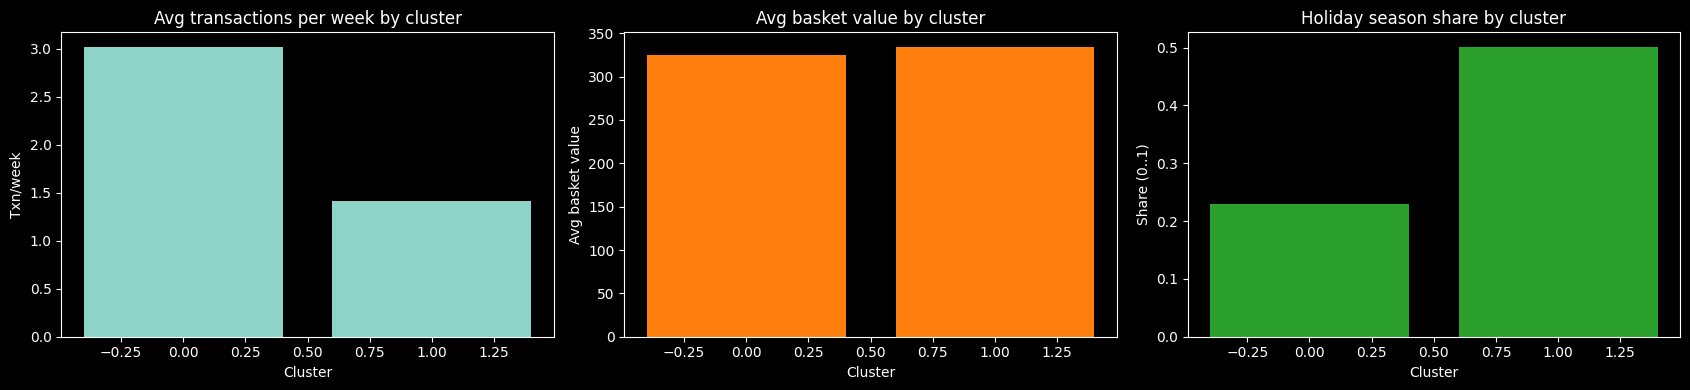

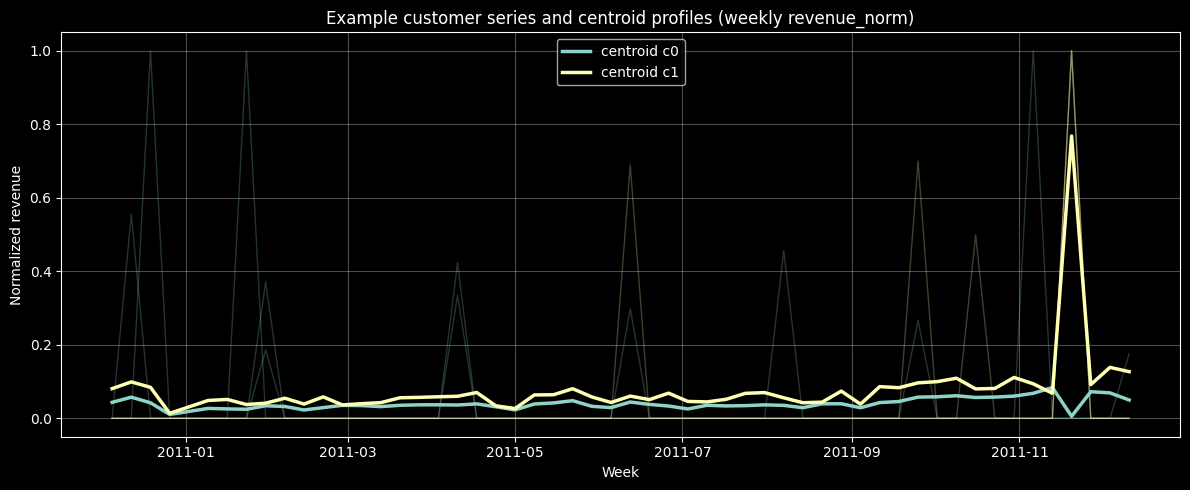

In [15]:
# Visualizations: key metrics per cluster and example customer series

fig, axes = plt.subplots(1, 3, figsize=(17, 4))

axes[0].bar(cluster_summary['cluster'], cluster_summary['avg_txn_per_week'])
axes[0].set_title('Avg transactions per week by cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Txn/week')

axes[1].bar(cluster_summary['cluster'], cluster_summary['avg_basket_value'], color='tab:orange')
axes[1].set_title('Avg basket value by cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Avg basket value')

axes[2].bar(cluster_summary['cluster'], cluster_summary['share_holiday_season_mean'], color='tab:green')
axes[2].set_title('Holiday season share by cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Share (0..1)')

plt.tight_layout()
plt.show()

# Plot a few example customer series per cluster (weekly revenue_norm)
max_examples = 3

# Build wide_week matrix if absent
if 'wide_week' not in globals():
    week_csv = os.path.join(DATA_DIR, 'customer_timeseries_week.csv')
    assert os.path.exists(week_csv), 'customer_timeseries_week.csv not found. Run the time-series aggregation first.'
    tsw_tmp = pd.read_csv(week_csv, parse_dates=['period'])
    metric = 'revenue_norm' if 'revenue_norm' in tsw_tmp.columns else 'txn_count_norm'
    raw_tmp = tsw_tmp[['CustomerID','period',metric]].copy()
    wide_week = raw_tmp.pivot_table(index='CustomerID', columns='period', values=metric, aggfunc='mean').fillna(0.0)

time_axis = list(wide_week.columns)

fig, ax = plt.subplots(figsize=(12, 5))
for c in sorted(assign_df['cluster'].unique()):
    c_ids = assign_df[assign_df['cluster'] == c]['CustomerID'].head(max_examples).tolist()
    for cid in c_ids:
        if cid in wide_week.index:
            ax.plot(time_axis, wide_week.loc[cid].values, alpha=0.25, linewidth=1.0, label=None, color=f'C{c}')

# Overlay centroid mean profiles (already computed as `profiles`)
for cid, grp in profiles.groupby('cluster'):
    ax.plot(grp['period'], grp['mean_revenue_norm'], linewidth=2.5, label=f'centroid c{cid}')

ax.set_title('Example customer series and centroid profiles (weekly revenue_norm)')
ax.set_xlabel('Week')
ax.set_ylabel('Normalized revenue')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


# Cluster visualization
#
# In this section we visualize the clustering results to highlight
# differences between clusters. We plot:
# - cluster size distribution;
# - bar charts for key KPIs by cluster (avg transactions/week, avg basket value,
#   holiday season share);
# - centroid mean profiles over time (weekly revenue_norm);
# - optional 2D PCA projection of customers colored by cluster.


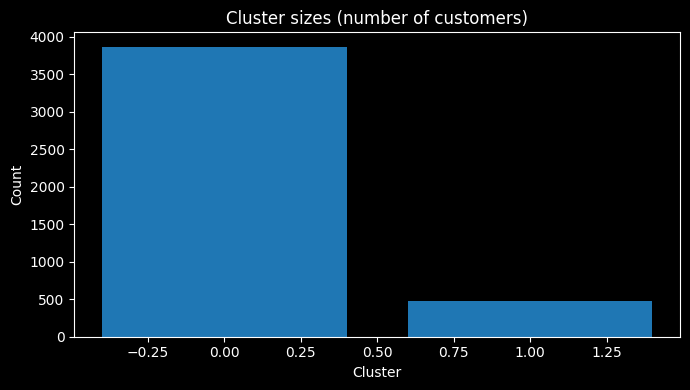

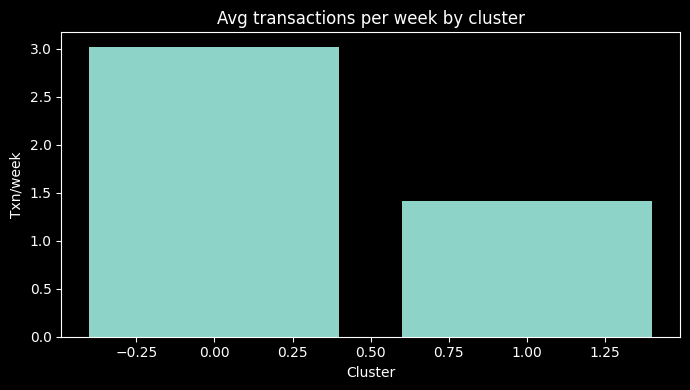

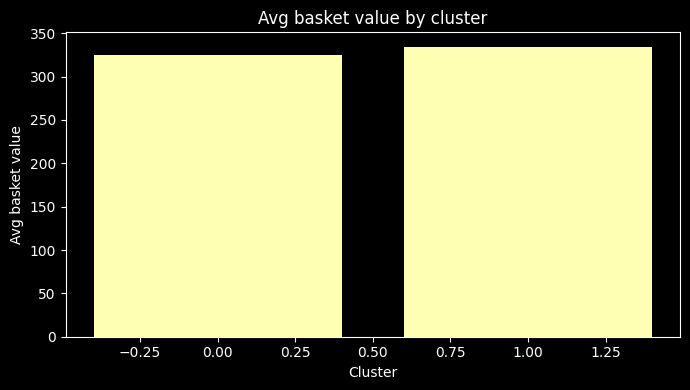

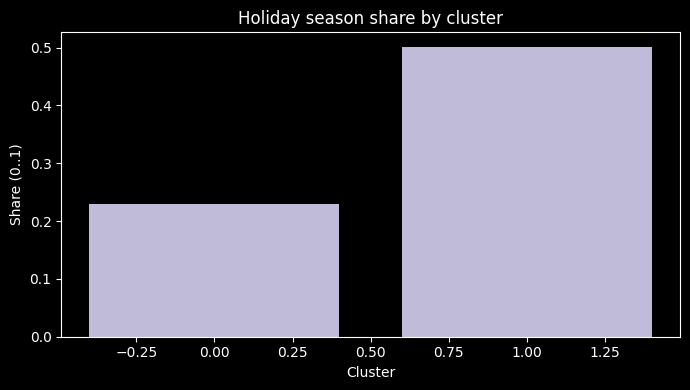

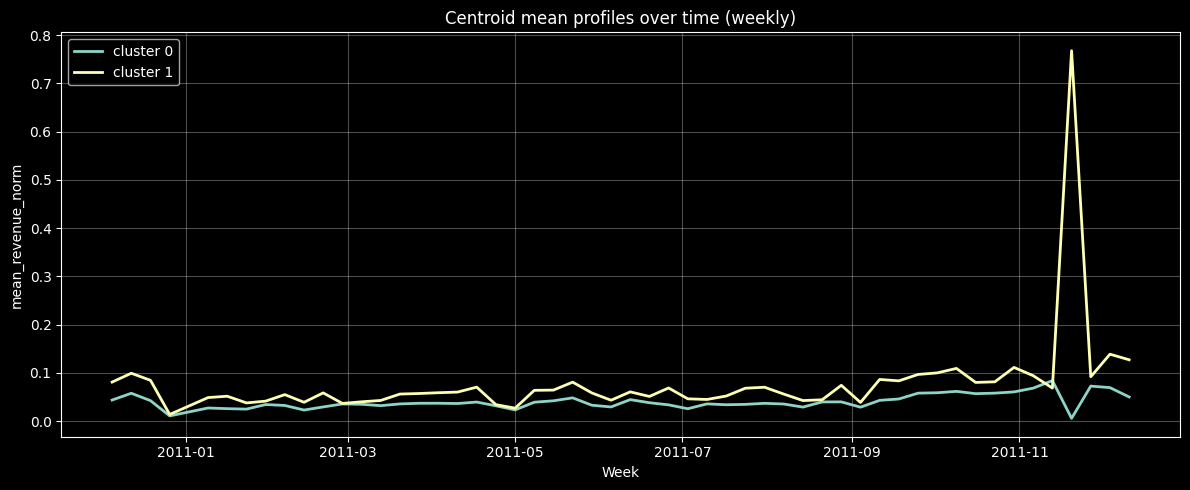

PCA visualization skipped: Line2D.set() got an unexpected keyword argument 'title'


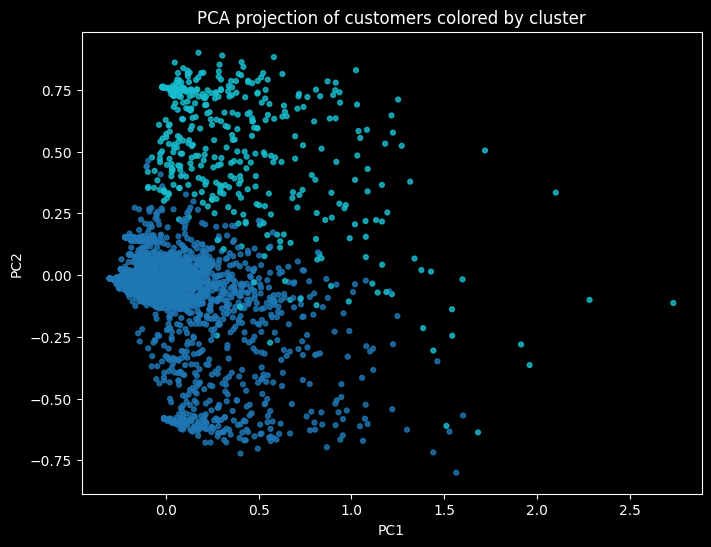

In [16]:
# Basic sanity checks for required inputs
assert os.path.exists(CLUSTERS_ASSIGN_PATH), 'cluster_assignments_week.csv is missing. Run the clustering section first.'
assert os.path.exists(CLUSTERS_PROFILE_PATH), 'cluster_profiles_week.csv is missing. Run the clustering section first.'

assign_df = pd.read_csv(CLUSTERS_ASSIGN_PATH)
profiles = pd.read_csv(CLUSTERS_PROFILE_PATH, parse_dates=['period'])

# Merge with previously computed cluster_summary if available; otherwise recompute minimal stats
CLUSTERS_SUMMARY_PATH = os.path.join(DATA_DIR, 'cluster_summary_week.csv')
if os.path.exists(CLUSTERS_SUMMARY_PATH):
    cluster_summary = pd.read_csv(CLUSTERS_SUMMARY_PATH)
else:
    # Minimal fallback: compute size per cluster
    cluster_summary = (assign_df.groupby('cluster')
                       .agg(size=('CustomerID', 'nunique'))
                       .reset_index())

# 1) Cluster size distribution
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(cluster_summary['cluster'], cluster_summary['size'], color='tab:blue')
ax.set_title('Cluster sizes (number of customers)')
ax.set_xlabel('Cluster')
ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# 2) KPI bar charts (if columns exist). We check presence before plotting.
def safe_bar(column: str, title: str, ylabel: str, color: str = 'C0'):
    if column in cluster_summary.columns:
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.bar(cluster_summary['cluster'], cluster_summary[column], color=color)
        ax.set_title(title)
        ax.set_xlabel('Cluster')
        ax.set_ylabel(ylabel)
        plt.tight_layout()
        plt.show()

safe_bar('avg_txn_per_week', 'Avg transactions per week by cluster', 'Txn/week', 'C0')
safe_bar('avg_basket_value', 'Avg basket value by cluster', 'Avg basket value', 'C1')
safe_bar('share_holiday_season_mean', 'Holiday season share by cluster', 'Share (0..1)', 'C2')

# 3) Centroid profiles over time (weekly revenue_norm)
if {'cluster', 'period'}.issubset(profiles.columns):
    # Try to detect the mean profile column name
    value_cols = [c for c in profiles.columns if c not in ['cluster', 'period']]
    if value_cols:
        val_col = value_cols[0]
        fig, ax = plt.subplots(figsize=(12, 5))
        for cid, grp in profiles.groupby('cluster'):
            ax.plot(grp['period'], grp[val_col], label=f'cluster {cid}', linewidth=2.0)
        ax.set_title('Centroid mean profiles over time (weekly)')
        ax.set_xlabel('Week')
        ax.set_ylabel(val_col)
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.tight_layout()
        plt.show()

# 4) PCA 2D projection (optional): customers colored by cluster
try:
    from sklearn.decomposition import PCA
    # Build the same matrix used for clustering
    week_csv = os.path.join(DATA_DIR, 'customer_timeseries_week.csv')
    assert os.path.exists(week_csv), 'customer_timeseries_week.csv not found. Run the time-series aggregation first.'
    tsw = pd.read_csv(week_csv, parse_dates=['period'])
    metric = 'revenue_norm' if 'revenue_norm' in tsw.columns else 'txn_count_norm'
    raw = tsw[['CustomerID', 'period', metric]].copy()
    wide = raw.pivot_table(index='CustomerID', columns='period', values=metric, aggfunc='mean').fillna(0.0)
    # Align to assignments
    common_ids = sorted(set(wide.index).intersection(set(assign_df['CustomerID'])))
    X_vis = wide.loc[common_ids].values
    labels_vis = assign_df.set_index('CustomerID').loc[common_ids]['cluster'].values
    # PCA to 2D
    pca = PCA(n_components=2, random_state=42)
    XY = pca.fit_transform(X_vis)
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(XY[:, 0], XY[:, 1], c=labels_vis, cmap='tab10', s=12, alpha=0.8)
    ax.set_title('PCA projection of customers colored by cluster')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    legend1 = ax.legend(*scatter.legend_elements(title='Cluster'), loc='best', frameon=True)
    ax.add_artist(legend1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('PCA visualization skipped:', e)


# Time series aggregation and per-customer normalization


In [17]:
# Aggregate transactions into time series by day/week/month and normalize per customer.
# We produce simple metrics per period:
# - txn_count: number of unique invoices (transactions)
# - revenue: sum of clipped total price
# Normalization: for each customer, scale each metric to [0, 1] by dividing by the
# customer's maximum value across the available periods (simple and robust).

def aggregate_timeseries(sales_df: pd.DataFrame, freq: str, label: str):
    """Aggregate sales into a customer-period time series and normalize per customer.

    Args:
        sales_df: Cleaned sales DataFrame with columns 'CustomerID', 'InvoiceDate',
                  'InvoiceNo', and 'TotalPrice_clipped'.
        freq: Pandas offset alias for resampling (e.g., 'D', 'W', 'M').
        label: Suffix label used in the saved CSV file name.

    Returns:
        A small preview (head) of the aggregated DataFrame.
    """
    # Ensure datetime index for time-based grouping
    tmp = sales_df.copy()
    tmp['InvoiceDate'] = pd.to_datetime(tmp['InvoiceDate'])

    agg = (tmp
           .set_index('InvoiceDate')
           .groupby(['CustomerID', pd.Grouper(freq=freq)])
           .agg(
               txn_count=('InvoiceNo', 'nunique'),
               revenue=('TotalPrice_clipped', 'sum'),
           )
           .reset_index()
           .rename(columns={'InvoiceDate': 'period'})
          )

    # Drop rows with missing period just in case
    agg = agg.dropna(subset=['period'])

    # Per-customer min-max to [0,1] using max (simple scale by max). If max == 0 -> 0s.
    for col in ['txn_count', 'revenue']:
        max_per_cust = agg.groupby('CustomerID')[col].transform('max')
        agg[f'{col}_norm'] = np.where(max_per_cust > 0, agg[col] / max_per_cust, 0.0)

    # Clean infinities if any and save
    agg = agg.replace([np.inf, -np.inf], np.nan)

    out_path = os.path.join(DATA_DIR, f'customer_timeseries_{label}.csv')
    agg.to_csv(out_path, index=False)
    print(f'Saved {label} time series to:', out_path)
    return agg.head(3)


# Build and save daily, weekly, and monthly series
ts_day_preview = aggregate_timeseries(sales, 'D', 'day')
ts_week_preview = aggregate_timeseries(sales, 'W', 'week')
ts_month_preview = aggregate_timeseries(sales, 'M', 'month')

# Show small previews for sanity check
ts_day_preview, ts_week_preview, ts_month_preview


Saved day time series to: data/customer_timeseries_day.csv
Saved week time series to: data/customer_timeseries_week.csv
Saved month time series to: data/customer_timeseries_month.csv


(   CustomerID     period  txn_count  revenue  txn_count_norm  revenue_norm
 0     12346.0 2011-01-18          1    42.64             1.0      1.000000
 1     12347.0 2010-12-07          1   711.79             1.0      0.555309
 2     12347.0 2011-01-26          1   475.39             1.0      0.370880,
    CustomerID     period  txn_count  revenue  txn_count_norm  revenue_norm
 0     12346.0 2011-01-23          1    42.64             1.0      1.000000
 1     12347.0 2010-12-12          1   711.79             1.0      0.555309
 2     12347.0 2011-01-30          1   475.39             1.0      0.370880,
    CustomerID     period  txn_count  revenue  txn_count_norm  revenue_norm
 0     12346.0 2011-01-31          1    42.64             1.0      1.000000
 1     12347.0 2010-12-31          1   711.79             1.0      0.555309
 2     12347.0 2011-01-31          1   475.39             1.0      0.370880)

# Customer time series clustering (simple baseline)


K candidates:
    K      inertia  silhouette
0   2  7236.917598    0.125682
1   3  7023.349598    0.104110
2   4  6805.434351    0.113824
3   5  6674.224027    0.093825
4   6  6479.522215    0.105121
5   7  6372.784825    0.093089
6   8  6267.130667    0.103733
7   9  6025.002243    0.123216
8  10  5992.279585    0.106451
Chosen K by max silhouette: 2
Saved cluster assignments to: data/cluster_assignments_week.csv
Saved cluster profiles to: data/cluster_profiles_week.csv


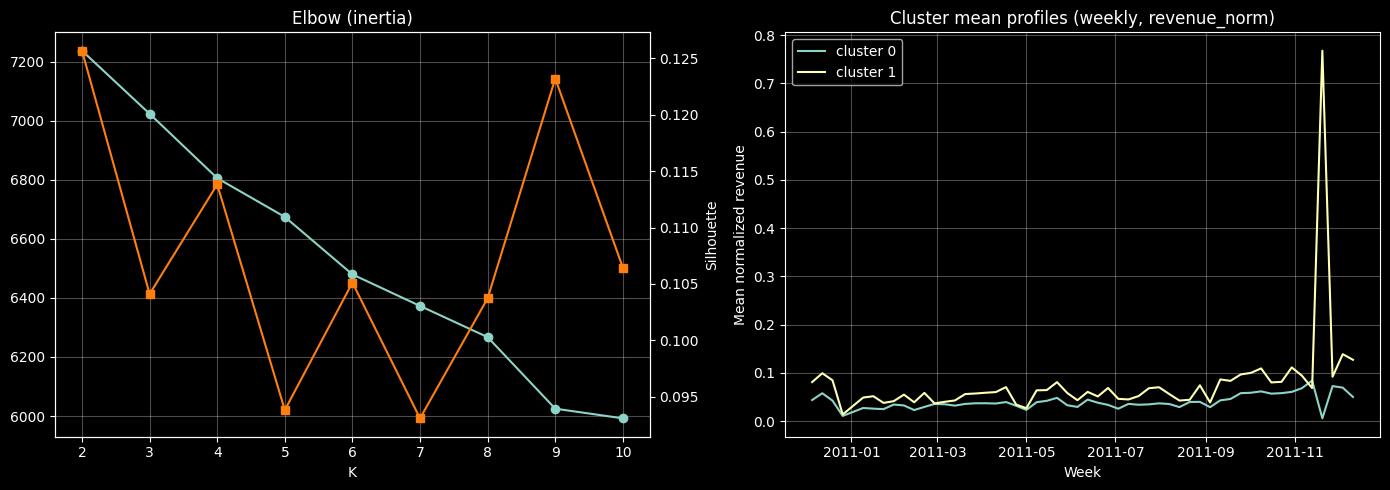

In [18]:
# In this section we perform a simple weekly time-series clustering using
# KMeans with Euclidean distance. We choose the number of clusters via the
# elbow method and average silhouette. This keeps dependencies minimal and
# is easy to reproduce.

from typing import Tuple, List
# Ensure scikit-learn is available when running this notebook section
try:
    import sklearn  # noqa: F401
except ModuleNotFoundError:
    import sys, subprocess
    print("Installing scikit-learn (missing)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn>=1.2"])  # installs into the current kernel
    import sklearn  # noqa: F401
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Paths for clustering outputs
CLUSTERS_ASSIGN_PATH = os.path.join(DATA_DIR, 'cluster_assignments_week.csv')
CLUSTERS_PROFILE_PATH = os.path.join(DATA_DIR, 'cluster_profiles_week.csv')


def load_weekly_series(metric: str = 'revenue_norm') -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Load weekly time series and prepare a wide matrix (customers × time).

    Args:
        metric: one of normalized metrics, e.g., 'revenue_norm' or 'txn_count_norm'.

    Returns:
        tuple: (raw_long, wide_matrix, index_map)
            raw_long: long-format DataFrame with [CustomerID, period, metric]
            wide_matrix: customers×periods matrix with missing periods filled with 0
            index_map: Series mapping matrix index to CustomerID
    """
    week_path = os.path.join(DATA_DIR, 'customer_timeseries_week.csv')
    assert os.path.exists(week_path), 'Weekly CSV not found. Run the aggregation cells above first.'
    tsw = pd.read_csv(week_path, parse_dates=['period'])

    # Keep only the selected metric
    cols_needed = ['CustomerID', 'period', metric]
    missing = [c for c in cols_needed if c not in tsw.columns]
    assert not missing, f'Missing columns in weekly CSV: {missing}'
    raw = tsw[cols_needed].copy()

    # Convert to wide format: rows — customers, columns — weekly periods
    wide = raw.pivot_table(index='CustomerID', columns='period', values=metric, aggfunc='mean')
    wide = wide.sort_index(axis=1)  # sort by time
    wide = wide.fillna(0.0)  # fill missing periods with zeros

    return raw, wide, wide.index.to_series()


def choose_k_elbow_silhouette(X: np.ndarray, k_range: List[int]) -> Tuple[int, pd.DataFrame]:
    """Pick K using elbow (inertia) and average silhouette.

    Returns:
        best_k, df_metrics (columns: K, inertia, silhouette)
    """
    rows = []
    best_k, best_sil = None, -1.0
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(X)
        inertia = float(km.inertia_)
        sil = silhouette_score(X, labels, metric='euclidean') if k > 1 and len(np.unique(labels)) > 1 else np.nan
        rows.append({'K': k, 'inertia': inertia, 'silhouette': sil})
        if not np.isnan(sil) and sil > best_sil:
            best_sil, best_k = sil, k
    return (best_k if best_k is not None else k_range[0]), pd.DataFrame(rows)


# Load weekly series and build the feature matrix
raw_week, wide_week, customer_index = load_weekly_series(metric='revenue_norm')
X = wide_week.values

# Try a simple K range
k_values = list(range(2, 11))
best_k, k_table = choose_k_elbow_silhouette(X, k_values)
print('K candidates:')
print(k_table)
print('Chosen K by max silhouette:', best_k)

# Fit the final model
final_kmeans = KMeans(n_clusters=int(best_k), n_init=50, random_state=42)
final_labels = final_kmeans.fit_predict(X)

# Save cluster assignments
assign_df = pd.DataFrame({'CustomerID': customer_index.values, 'cluster': final_labels})
assign_df.to_csv(CLUSTERS_ASSIGN_PATH, index=False)
print('Saved cluster assignments to:', CLUSTERS_ASSIGN_PATH)

# Cluster profiles: mean time profiles per cluster
centroids = pd.DataFrame(final_kmeans.cluster_centers_, columns=wide_week.columns)
centroids['cluster'] = range(centroids.shape[0])

profiles = centroids.melt(id_vars='cluster', var_name='period', value_name='mean_'+ 'revenue_norm')
profiles = profiles.sort_values(['cluster', 'period'])
profiles.to_csv(CLUSTERS_PROFILE_PATH, index=False)
print('Saved cluster profiles to:', CLUSTERS_PROFILE_PATH)

# Visualization: elbow and cluster profiles
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow (inertia) and silhouette on secondary axis
ax1 = axes[0]
ax1.plot(k_table['K'], k_table['inertia'], '-o', label='Inertia')
ax1.set_xlabel('K')
ax1.set_title('Elbow (inertia)')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(k_table['K'], k_table['silhouette'], '-s', color='tab:orange', label='Silhouette')
ax2.set_ylabel('Silhouette')

# Cluster mean profiles
axp = axes[1]
for cid, grp in profiles.groupby('cluster'):
    axp.plot(grp['period'], grp['mean_revenue_norm'], label=f'cluster {cid}')
axp.set_title('Cluster mean profiles (weekly, revenue_norm)')
axp.set_xlabel('Week')
axp.set_ylabel('Mean normalized revenue')
axp.legend()
axp.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
